## Import Library

In [23]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import numpy as np
import math
from scipy.spatial import distance

# Import Data

In [24]:
datapoi = pd.read_csv('/content/POI-Vien.csv', sep=";")
datacost = pd.read_csv('/content/costProfCat-VienPOI-all.csv', sep=";")
datauser = pd.read_csv('/content/userVisits-Vien-allPOI.csv', sep=";")
print(datapoi.head())
print(datacost.head())
print(datauser.head())

   poiID                     poiName        lat       long          theme
0      1      Sch%C3%B6nbrunn_Palace  48.184516  16.311865         Palace
1      2  Tiergarten_Sch%C3%B6nbrunn  48.182220  16.302500            Zoo
2      3            Wiener_Riesenrad  48.216651  16.395949  Entertainment
3      4           Albertina,_Vienna  48.204440  16.367780         Museum
4      5              Hofburg_Palace  48.206507  16.365262         Palace
   from  to         cost  profit       category
0     1   2   740.592074    1478            Zoo
1     1   3  7191.613002    1243  Entertainment
2     1   4  4704.820017    1042         Museum
3     1   5  4657.538075    1750         Palace
4     1   6  4251.148487    1581         Museum
      photoID        userID   dateTaken  poiID   poiTheme  poiFreq  seqID
0  8703140158  10002536@N02  1367146438      8  Structure      571      1
1  8703142404  10002536@N02  1367146924      8  Structure      571      1
2  8703142278  10002536@N02  1367147103      8

# Preprocessing

Gabungkan data

In [25]:
# Gabungkan untuk kolom 'from'
data_merged = datacost.merge(datapoi[['poiID', 'poiName', 'lat', 'long', 'theme']],
                             left_on='from', right_on='poiID', how='left')
data_merged.rename(columns={'poiName': 'fromName', 'lat': 'fromLat', 'long': 'fromLong', 'theme': 'categoryFrom'}, inplace=True)


# Gabungkan untuk kolom 'to'
data_merged = data_merged.merge(datapoi[['poiID', 'poiName', 'lat', 'long', 'theme']],
                                 left_on='to', right_on='poiID', how='left')
data_merged.rename(columns={'poiName': 'toName', 'lat': 'toLat', 'long': 'toLong', 'theme': 'categoryTo'}, inplace=True)


# Hapus kolom 'poiID' tambahan
data_merged.drop(columns=['poiID_x', 'poiID_y'], inplace=True)
# Susun ulang kolom agar lebih rapi
data_merged = data_merged[['fromName', 'toName', 'fromLat', 'fromLong', 'toLat', 'toLong', 'cost', 'profit', 'categoryFrom', 'categoryTo']]


# Misalkan data Anda ada dalam DataFrame bernama data_merged
data_merged['fromName'] = data_merged['fromName'].apply(urllib.parse.unquote)
data_merged['toName'] = data_merged['toName'].apply(urllib.parse.unquote)


# Hasil akhir
print(data_merged)

                  fromName                        toName    fromLat  \
0        Schönbrunn_Palace         Tiergarten_Schönbrunn  48.184516   
1        Schönbrunn_Palace              Wiener_Riesenrad  48.184516   
2        Schönbrunn_Palace             Albertina,_Vienna  48.184516   
3        Schönbrunn_Palace                Hofburg_Palace  48.184516   
4        Schönbrunn_Palace      Kunsthistorisches_Museum  48.184516   
..                     ...                           ...        ...   
751  Wüstenhaus_Schönbrunn         Palmenhaus_Schönbrunn  48.184720   
752  Wüstenhaus_Schönbrunn     Austrian_National_Library  48.184720   
753  Wüstenhaus_Schönbrunn  Austrian_Parliament_Building  48.184720   
754  Wüstenhaus_Schönbrunn             Mozarthaus_Vienna  48.184720   
755  Wüstenhaus_Schönbrunn  Heeresgeschichtliches_Museum  48.184720   

      fromLong      toLat     toLong         cost  profit categoryFrom  \
0    16.311865  48.182220  16.302500   740.592074    1478       Palace   

Cek data duplikat

In [26]:
# Cek duplikat pada seluruh DataFrame
duplicates = data_merged[data_merged.duplicated()]

# Tampilkan duplikat
print(duplicates)

Empty DataFrame
Columns: [fromName, toName, fromLat, fromLong, toLat, toLong, cost, profit, categoryFrom, categoryTo]
Index: []


Cek nilai hilang

In [27]:
missing_values = data_merged.isnull().sum()

# Tampilkan jumlah nilai hilang per kolom
print(missing_values)

fromName        0
toName          0
fromLat         0
fromLong        0
toLat           0
toLong          0
cost            0
profit          0
categoryFrom    0
categoryTo      0
dtype: int64


Salin data

In [28]:
data_merged.to_excel('/content/data_merged.xlsx', index=False)

# Visualisasi

Visualisasi lokasi tiap POI dengan kategorinya

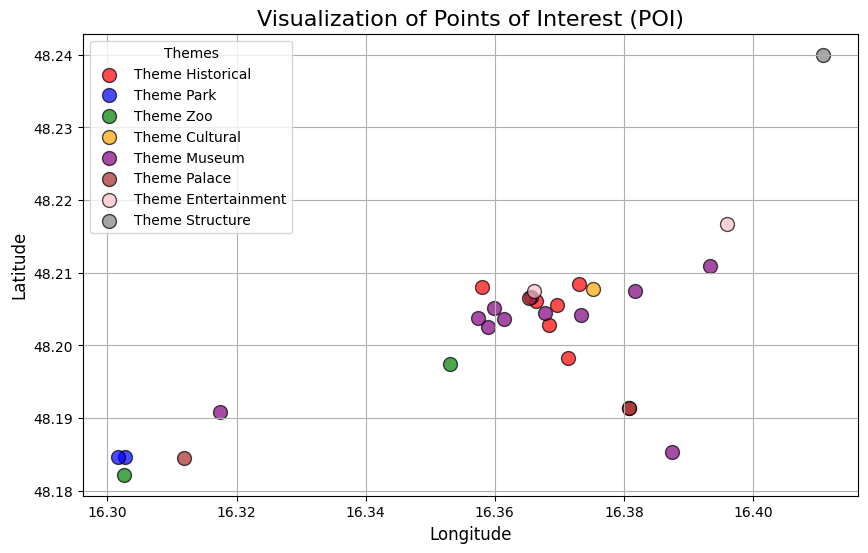

In [29]:
colors = {
    'Historical': 'red', 'Park': 'blue', 'Zoo': 'green', 'Cultural': 'orange',
    'Museum': 'purple', 'Palace': 'brown', 'Entertainment': 'pink', 'Structure': 'gray'
}

# Mengambil latitudes dan longitudes
latitudes = datapoi['lat']
longitudes = datapoi['long']
themes = datapoi['theme']

# Plotting
plt.figure(figsize=(10, 6))
for theme in colors.keys():
    # Filter data berdasarkan tema
    filtered_data = datapoi[datapoi['theme'] == theme]
    plt.scatter(filtered_data['long'], filtered_data['lat'],
                c=colors[theme], label=f'Theme {theme}',
                alpha=0.7, edgecolors='k', s=100)

# Menambahkan detail
plt.title('Visualization of Points of Interest (POI)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title="Themes", fontsize=10)
plt.grid(True)
plt.show()

Titik POI dengan keuntungan terbanyak

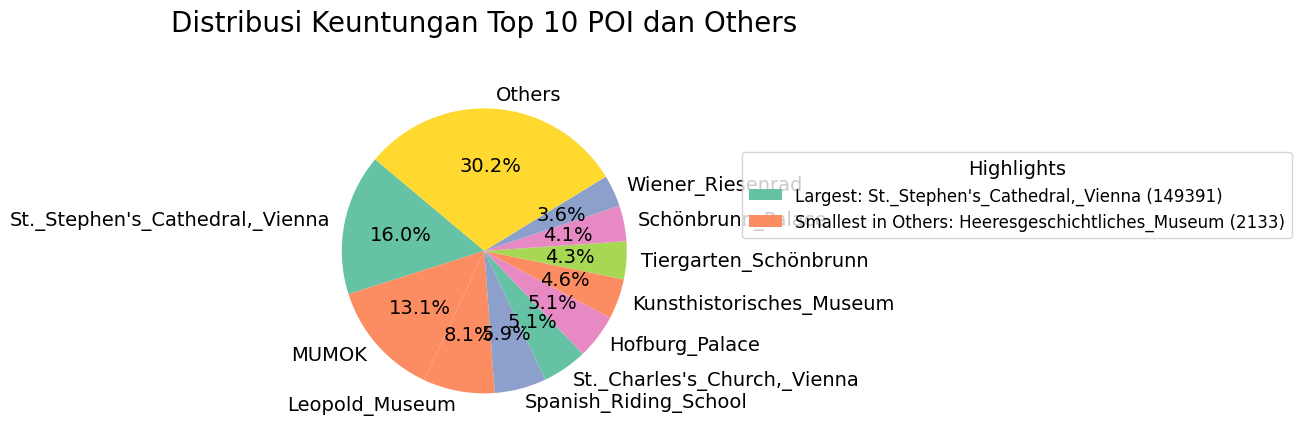

In [31]:
# Menghitung total keuntungan untuk setiap 'toName'
profit_summary = data_merged.groupby(['toName', 'categoryTo'])['profit'].sum().sort_values(ascending=False).reset_index()

# Pisahkan top 10 POI dan gabungkan sisanya ke "Others"
top_10 = profit_summary.head(10)
others = profit_summary.iloc[10:]
others_sum = others['profit'].sum()
others_row = pd.DataFrame([{
    'toName': 'Others',
    'categoryTo': 'Others',
    'profit': others_sum
}])
profit_summary_revised = pd.concat([top_10, others_row], ignore_index=True)

# Menentukan entitas dengan profit terbesar dan terkecil (dari Others)
largest_entity = profit_summary_revised.iloc[0]
smallest_in_others = others.loc[others['profit'].idxmin()] if not others.empty else None

# Membuat mapping warna berdasarkan kategori
category_colors = {category: color for category, color in zip(profit_summary_revised['categoryTo'].unique(), sns.color_palette("Set2", len(profit_summary_revised['categoryTo'].unique())))}

# Warna untuk kategori
label_colors = [category_colors[cat] for cat in profit_summary_revised['categoryTo']]

# Membuat pie chart
plt.figure(figsize=(14, 14))  # Ukuran plot lebih besar
plt.pie(profit_summary_revised['profit'],
        labels=profit_summary_revised['toName'],
        autopct='%1.1f%%',
        startangle=140,
        colors=[category_colors[cat] for cat in profit_summary_revised['categoryTo']],
        textprops={'fontsize': 14})  # Font lebih besar

plt.title("Distribusi Keuntungan Top 10 POI dan Others", fontsize=20, pad=30)  # Judul dengan font besar dan padding lebih luas

# Tambahkan legenda untuk entitas terbesar dan terkecil
legend_texts = [
    f"Largest: {largest_entity['toName']} ({largest_entity['profit']:.0f})",
]
if smallest_in_others is not None:
    legend_texts.append(f"Smallest in Others: {smallest_in_others['toName']} ({smallest_in_others['profit']:.0f})")

plt.legend(legend_texts, title="Highlights", loc="upper left", bbox_to_anchor=(1.2, 0.8), fontsize=12, title_fontsize=14)  # Legenda diperbesar

plt.tight_layout()
plt.show()

Kunjungan terbanyak berdasarkan kategori

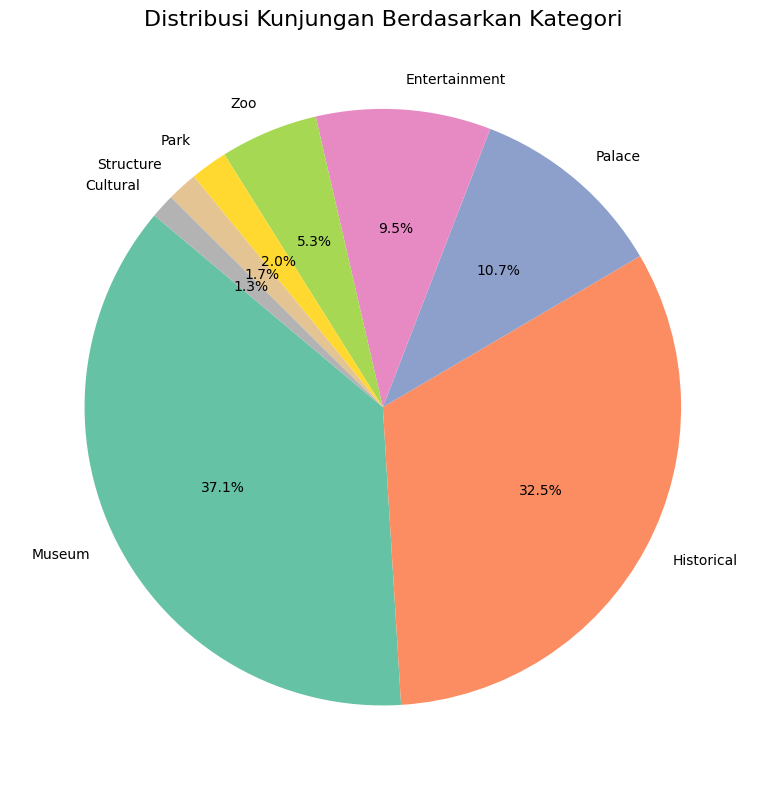

In [33]:
category_profit = data_merged.groupby('categoryTo')['profit'].sum().sort_values(ascending=False)

# Membuat mapping warna berdasarkan kategori
category_colors = {category: color for category, color in zip(category_profit.index, sns.color_palette("Set2", len(category_profit.index)))}

# Membuat pie chart berdasarkan kategori
plt.figure(figsize=(8, 8))
plt.pie(category_profit.values, labels=category_profit.index, autopct='%1.1f%%', startangle=140,
        colors=[category_colors[cat] for cat in category_profit.index])

plt.title("Distribusi Kunjungan Berdasarkan Kategori", fontsize=16)
plt.tight_layout()
plt.show()

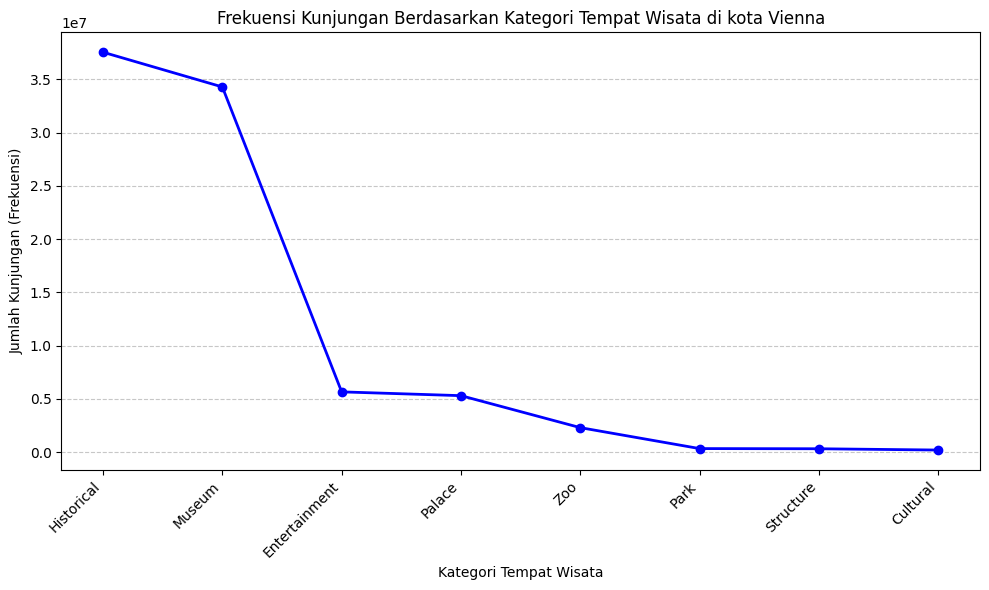

In [34]:
# Mengelompokkan data berdasarkan 'poiTheme' dan menjumlahkan 'poiFreq'
grouped_data = datauser.groupby('poiTheme')['poiFreq'].sum().reset_index()


# Mengurutkan data berdasarkan frekuensi kunjungan tertinggi
sorted_data = grouped_data.sort_values(by='poiFreq', ascending=False)


# Visualisasi Line Chart
plt.figure(figsize=(10, 6))
plt.plot(sorted_data['poiTheme'], sorted_data['poiFreq'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kategori Tempat Wisata')
plt.ylabel('Jumlah Kunjungan (Frekuensi)')
plt.title('Frekuensi Kunjungan Berdasarkan Kategori Tempat Wisata di kota Vienna')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Pola kunjungan berdasarkan waktu

            dateTaken
0 2013-04-28 10:53:58
1 2013-04-28 11:02:04
2 2013-04-28 11:05:03
3 2013-04-28 11:05:54
4 2008-11-22 22:38:11


<ipython-input-15-e897f9193c5f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=datauser, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


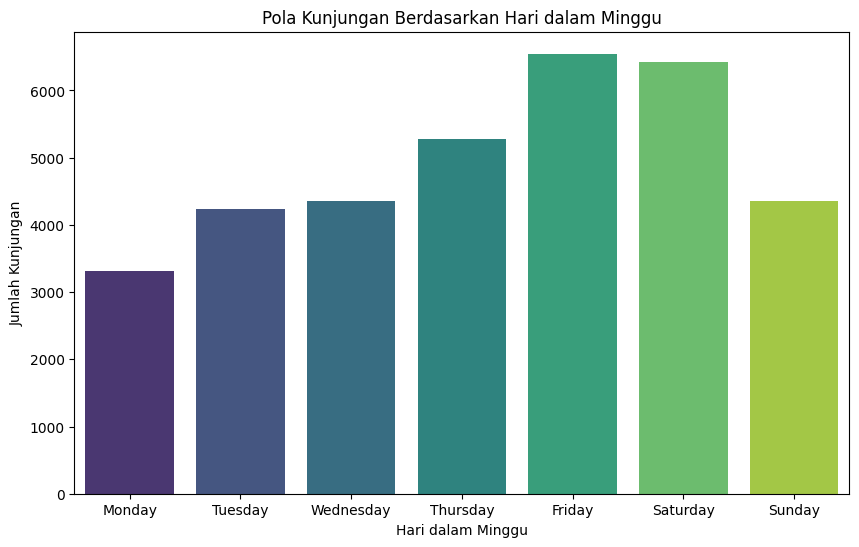

<ipython-input-15-e897f9193c5f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=datauser, palette='viridis', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'])


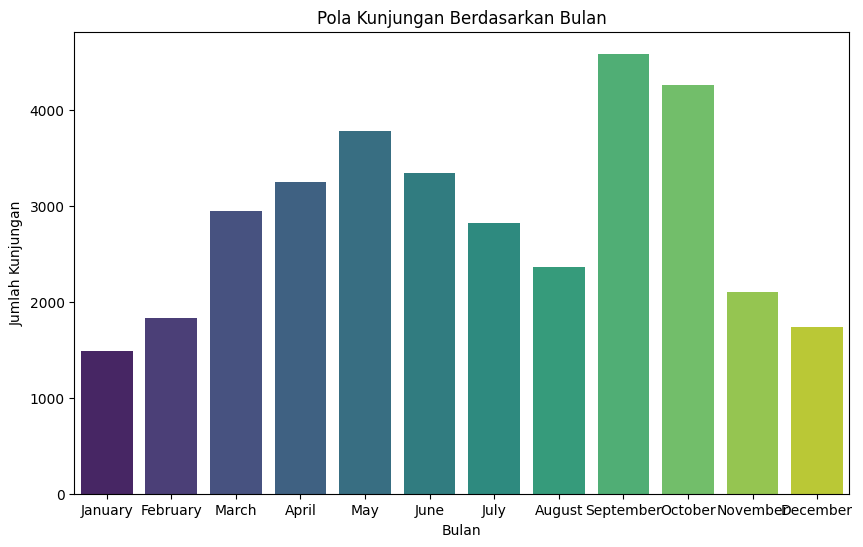

In [15]:
datauser['dateTaken'] = pd.to_datetime(datauser['dateTaken'], errors='coerce', unit='s')  # Mengubah timestamp ke datetime

# Menampilkan beberapa data awal untuk memastikan konversi berhasil
print(datauser[['dateTaken']].head())

# Ekstrak hari dalam minggu dan bulan dari 'dateTaken'
datauser['day_of_week'] = datauser['dateTaken'].dt.day_name()  # Nama hari (Senin, Selasa, dst)
datauser['month'] = datauser['dateTaken'].dt.month_name()  # Nama bulan (Januari, Februari, dst)

# Visualisasi pola kunjungan berdasarkan hari dalam minggu
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=datauser, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Pola Kunjungan Berdasarkan Hari dalam Minggu')
plt.xlabel('Hari dalam Minggu')
plt.ylabel('Jumlah Kunjungan')
plt.show()

# Visualisasi pola kunjungan berdasarkan bulan
plt.figure(figsize=(10, 6))
sns.countplot(x='month', data=datauser, palette='viridis', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'])
plt.title('Pola Kunjungan Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kunjungan')
plt.show()

Kemungkinan pengunjung memilih tujuan dengan kategori yang sama

In [ ]:
# Menghitung jumlah baris di mana categoryFrom sama dengan categoryTo
same_category_data = data_merged[data_merged['categoryFrom'] == data_merged['categoryTo']]

# Menghitung jumlah profit dan kategori untuk data yang memenuhi kondisi
profit_by_category = same_category_data.groupby('categoryFrom')['profit'].sum()

# Menampilkan jumlah profit untuk setiap kategori
print(f"Jumlah profit berdasarkan kategori (categoryFrom == categoryTo):")
print(profit_by_category)

# Menghitung jumlah baris dan total profit
same_category_count = same_category_data.shape[0]
total_count = data_merged.shape[0]
probability = same_category_count / total_count

# Menampilkan hasil lainnya
print(f"\nJumlah baris di mana categoryFrom sama dengan categoryTo: {same_category_count}")
print(f"Total jumlah baris: {total_count}")
print(f"Probabilitas bahwa categoryFrom sama dengan categoryTo: {probability:.2f}")

Jumlah profit berdasarkan kategori (categoryFrom == categoryTo):
categoryFrom
Entertainment      3273
Historical        56075
Museum           128060
Palace             7376
Park                694
Zoo                1830
Name: profit, dtype: int64

Jumlah baris di mana categoryFrom sama dengan categoryTo: 152
Total jumlah baris: 756
Probabilitas bahwa categoryFrom sama dengan categoryTo: 0.20


In [ ]:
same_category_profit = data_merged[data_merged['categoryFrom'] == data_merged['categoryTo']].groupby('categoryFrom')['profit'].sum()
category_to_profit = data_merged.groupby('categoryTo')['profit'].sum()
profit_ratio = same_category_profit / category_to_profit
profit_comparison_df = pd.DataFrame({
    'same_category_profit': same_category_profit,
    'category_to_profit': category_to_profit
})
profit_comparison_df['profit_ratio'] = profit_comparison_df['same_category_profit'] / profit_comparison_df['category_to_profit']
print(profit_comparison_df)

               same_category_profit  category_to_profit  profit_ratio
Cultural                        NaN               12231           NaN
Entertainment                3273.0               88371      0.037037
Historical                  56075.0              302805      0.185185
Museum                     128060.0              345762      0.370370
Palace                       7376.0               99576      0.074074
Park                          694.0               18738      0.037037
Structure                       NaN               15417           NaN
Zoo                          1830.0               49410      0.037037


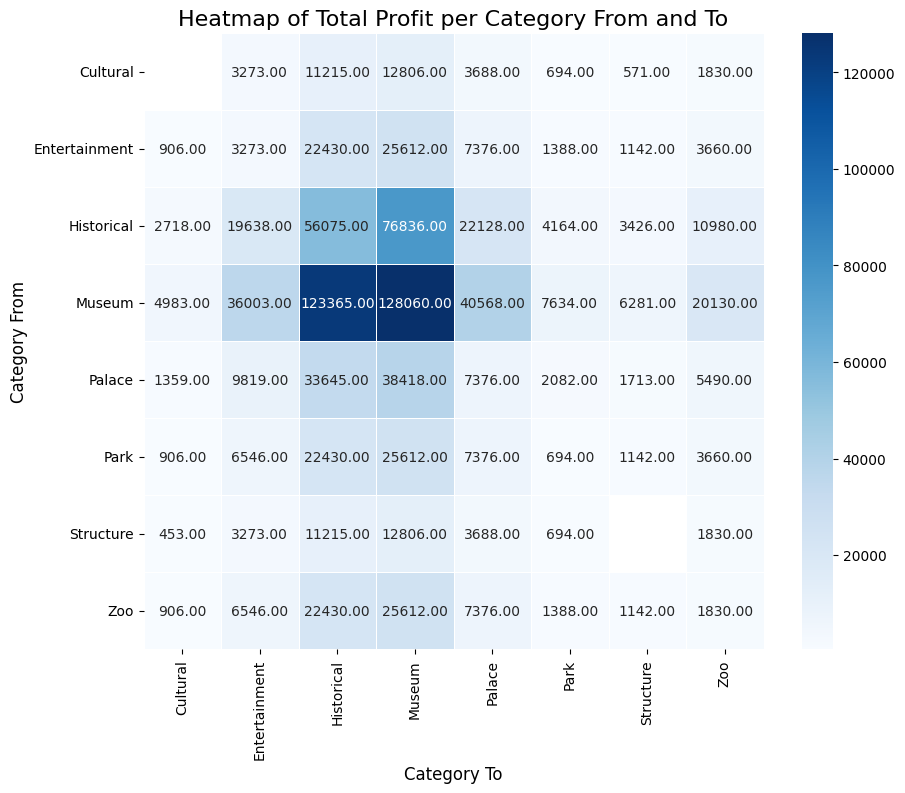

In [ ]:
total_profit_per_category = data_merged.groupby(['categoryFrom', 'categoryTo'])['profit'].sum().unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(total_profit_per_category, annot=True, fmt='.2f', cmap='Blues', linewidths=0.5, cbar=True)
plt.title('Heatmap of Total Profit per Category From and To', fontsize=16)
plt.xlabel('Category To', fontsize=12)
plt.ylabel('Category From', fontsize=12)
plt.show()